## Quantified Self : Analyzing Personal Garmin Data (2013-2019)

![title](activities.png)

In [79]:
# hack for windows
import os
os.environ["R_HOME"] = r"C:\Program Files\R\R-4.0.2"
os.environ["PATH"]   = r"C:\Program Files\R\R-4.0.2\bin\x64" + ";" + os.environ["PATH"]

In [80]:
import pandas as pd
import math
import warnings
import numpy as np
from rpy2.robjects import pandas2ri
pandas2ri.activate()
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (20,20)
%reload_ext rpy2.ipython
%matplotlib inline
pd.options.display.max_rows = 999
sns.set_style("white")

In [81]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;

    }
</style>
""")

### ii. Load Data

In [82]:
path = "GarminActivitiesDataset_Axenie"

frame = pd.DataFrame()
list_ = []

file_path = path + ".csv"
df = pd.read_csv(file_path, index_col=None, header=0)
list_.append(df)
frame = pd.concat(list_)
    
frame.reset_index(inplace=True)
frame.drop("index", axis=1, inplace=True)

In [83]:
col_names = ['activityType', 'startTime', 'actDistance',  'calories', 'activityTime', 'avgHR', 'maxHR', 'avgSpeed', 'elevationGain']
frame.columns = col_names

### iii. Data Cleaning

** Correcting Data Errors and Data Types **

In [84]:
frame["avgHR"] = frame["avgHR"].replace(['--'], np.NaN)
frame["maxHR"] = frame["maxHR"].replace(['--'], np.NaN)
frame['avgHR'] = frame.avgHR.astype(float)
frame['maxHR'] = frame.maxHR.astype(float)

In [85]:
frame["elevationGain"] = frame["elevationGain"].replace(['--', '0', 0], np.NaN)
frame['elevationGain'] = frame.elevationGain.astype(float)

In [86]:
frame["avgSpeed"] = frame["avgSpeed"].replace("--", np.NaN)
frame["avgSpeed"] = frame.avgSpeed.str.replace(":", ".")
frame['avgSpeed'] = frame.avgSpeed.astype(float)
frame['actDistance'] = frame.actDistance.astype(float)

In [87]:
frame['calories'] = frame.calories.astype(float)

In [88]:
frame.drop(frame[frame["actDistance"] < 0.01].index, axis=0, inplace=True)
frame.reset_index(inplace=True)
frame.drop("index", axis=1, inplace=True)

In [89]:
activity_tracker_data = frame.copy()

### iv. Exploring the data and the datatypes

** Initial Peek into the data **

In [90]:
activity_tracker_data = frame.copy()
activity_tracker_data.head()

,activityType,startTime,actDistance,calories,activityTime,avgHR,maxHR,avgSpeed,elevationGain
0,Running,2019-09-27 07:16:58,10.02,666.0,00:50:00,154.0,186.0,4.59,37.0
1,Running,2019-09-22 10:37:17,20.99,1388.0,01:29:39,176.0,189.0,4.16,476.0
2,Running,2019-09-20 07:08:07,10.00,729.0,00:53:56,154.0,175.0,5.24,45.0
3,Running,2019-09-18 07:03:26,10.01,696.0,00:50:34,156.0,169.0,5.03,54.0
4,Running,2019-09-16 06:59:14,10.01,716.0,00:53:01,160.0,185.0,5.18,52.0


### v. Data Transformations

Creating Derived Fields that can be used for the visualizations. The transformations have been highlighted.

** Converting startTime to Python DateTime Format to use the inbuilt functions **

In [91]:
activity_tracker_data["startTime"] = pd.to_datetime(activity_tracker_data["startTime"])
activity_tracker_data.head()

,activityType,startTime,actDistance,calories,activityTime,avgHR,maxHR,avgSpeed,elevationGain
0,Running,2019-09-27 07:16:58,10.02,666.0,00:50:00,154.0,186.0,4.59,37.0
1,Running,2019-09-22 10:37:17,20.99,1388.0,01:29:39,176.0,189.0,4.16,476.0
2,Running,2019-09-20 07:08:07,10.00,729.0,00:53:56,154.0,175.0,5.24,45.0
3,Running,2019-09-18 07:03:26,10.01,696.0,00:50:34,156.0,169.0,5.03,54.0
4,Running,2019-09-16 06:59:14,10.01,716.0,00:53:01,160.0,185.0,5.18,52.0


** Concatenating information about the Month and Year for every activity to the DataFrame **

In [92]:
activity_tracker_data["activityMonth"] = activity_tracker_data.startTime.dt.month
activity_tracker_data["activityDay"] = activity_tracker_data.startTime.dt.dayofweek

In [93]:
activity_tracker_data["activityMonthName"] = activity_tracker_data.activityMonth.map({1:"January", 2:"February", 3:"March", 4:"April",
                                                                   5:"May", 6:"June", 7:"July", 8:"August", 
                                                                   9:"September", 10:"October", 11:"November", 12:"December"})

In [94]:
activity_tracker_data["activityDayName"] = activity_tracker_data.activityDay.map({0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday",
                                                                   4:"Friday", 5:"Saturday", 6:"Sunday"})
activity_tracker_data

,activityType,startTime,actDistance,calories,activityTime,avgHR,maxHR,avgSpeed,elevationGain,activityMonth,activityDay,activityMonthName,activityDayName
0,Running,2019-09-27 07:16:58,10.020,666.0,00:50:00,154.0,186.0,4.59,37.000,9,4,September,Friday
1,Running,2019-09-22 10:37:17,20.990,1388.0,01:29:39,176.0,189.0,4.16,476.000,9,6,September,Sunday
2,Running,2019-09-20 07:08:07,10.000,729.0,00:53:56,154.0,175.0,5.24,45.000,9,4,September,Friday
3,Running,2019-09-18 07:03:26,10.010,696.0,00:50:34,156.0,169.0,5.03,54.000,9,2,September,Wednesday
4,Running,2019-09-16 06:59:14,10.010,716.0,00:53:01,160.0,185.0,5.18,52.000,9,0,September,Monday
5,Running,2019-09-14 09:40:40,10.000,677.0,00:50:59,150.0,165.0,5.06,50.000,9,5,September,Saturday
6,Running,2019-09-10 06:49:21,11.000,656.0,00:56:53,139.0,176.0,5.10,65.000,9,1,September,Tuesday
7,Running,2019-09-05 06:42:47,10.010,640.0,00:55:23,146.0,168.0,5.32,46.000,9,3,September,Thursday
8,Running,2019-09-03 06:52:36,10.010,708.0,00:55:23,153.0,170.0,5.32,47.000,9,1,September,Tuesday
9,Running,2019-08-31 09:08:28,10.010,666.0,00:53:14,145.0,153.0,5.19,43.000,8,5,August,Saturday


** Obtaining Activitiy Levels using the average HR field for all the workouts **

In [95]:
## Divide the Heart Rate Zones from the data into Zones and create a new column
def get_hr_zones(avgHR):
    if avgHR < 148:
        return "Light"
    elif avgHR >= 149 and avgHR < 166:
        return "Moderate"
    else:
        return "Hard"

In [96]:
activity_tracker_data["activityLevel"] = activity_tracker_data.avgHR.apply(get_hr_zones)
activity_tracker_data

,activityType,startTime,actDistance,calories,activityTime,avgHR,maxHR,avgSpeed,elevationGain,activityMonth,activityDay,activityMonthName,activityDayName,activityLevel
0,Running,2019-09-27 07:16:58,10.020,666.0,00:50:00,154.0,186.0,4.59,37.000,9,4,September,Friday,Moderate
1,Running,2019-09-22 10:37:17,20.990,1388.0,01:29:39,176.0,189.0,4.16,476.000,9,6,September,Sunday,Hard
2,Running,2019-09-20 07:08:07,10.000,729.0,00:53:56,154.0,175.0,5.24,45.000,9,4,September,Friday,Moderate
3,Running,2019-09-18 07:03:26,10.010,696.0,00:50:34,156.0,169.0,5.03,54.000,9,2,September,Wednesday,Moderate
4,Running,2019-09-16 06:59:14,10.010,716.0,00:53:01,160.0,185.0,5.18,52.000,9,0,September,Monday,Moderate
5,Running,2019-09-14 09:40:40,10.000,677.0,00:50:59,150.0,165.0,5.06,50.000,9,5,September,Saturday,Moderate
6,Running,2019-09-10 06:49:21,11.000,656.0,00:56:53,139.0,176.0,5.10,65.000,9,1,September,Tuesday,Light
7,Running,2019-09-05 06:42:47,10.010,640.0,00:55:23,146.0,168.0,5.32,46.000,9,3,September,Thursday,Light
8,Running,2019-09-03 06:52:36,10.010,708.0,00:55:23,153.0,170.0,5.32,47.000,9,1,September,Tuesday,Moderate
9,Running,2019-08-31 09:08:28,10.010,666.0,00:53:14,145.0,153.0,5.19,43.000,8,5,August,Saturday,Light


** Calculating total minutes of an activity from the data **

In [97]:
def getMinutes(activityTime):
    curr_time = activityTime.split(":")
    if len(curr_time) == 2:
        final_time = curr_time[0] + "." + curr_time[1]
    else:
        mins = int(curr_time[0])*60 + int(curr_time[1])
        final_time = str(mins) + "." + curr_time[2]
    return final_time

In [98]:
activity_tracker_data["activityMins"] = activity_tracker_data.activityTime.apply(getMinutes)
activity_tracker_data["activityMins"] = activity_tracker_data["activityMins"].astype("float")

In [99]:
activity_tracker_data.drop("activityTime", axis=1, inplace=True)

** Checking final data types **

In [100]:
activity_tracker_data.dtypes

activityType                 object
startTime            datetime64[ns]
actDistance                 float64
calories                    float64
avgHR                       float64
maxHR                       float64
avgSpeed                    float64
elevationGain               float64
activityMonth                 int64
activityDay                   int64
activityMonthName            object
activityDayName              object
activityLevel                object
activityMins                float64
dtype: object

** Creating a list of continuous and categorical variable **

In [101]:
categorical_vars = activity_tracker_data.describe(include=["object"]).columns
continuous_vars = activity_tracker_data.describe().columns

### vi. Summary of Continuous Variables and Missing Data Analysis

** The summary of continuous variables helps us figure out the count of values for all the variables where the values are present. It helps us explore the number of missing values for the variables and begin the analysis of MISSING DATA **

In [102]:
activity_tracker_data.describe()

,actDistance,calories,avgHR,maxHR,avgSpeed,elevationGain,activityMonth,activityDay,activityMins
count,544.000000,544.000000,237.000000,237.000000,543.000000,360.000000,544.000000,544.000000,544.000000
mean,10.014726,684.433824,152.607595,171.928270,4.217827,78.829997,6.836397,3.036765,52.557151
std,10.075876,476.097587,13.723743,11.103477,2.109889,103.020313,3.190236,2.063122,33.514784
min,0.484000,80.000000,75.000000,98.000000,1.440000,1.011000,1.000000,0.000000,8.490000
25%,1.662500,300.000000,148.000000,167.000000,2.350000,31.000000,4.000000,1.000000,29.137500
50%,10.000000,653.500000,154.000000,172.000000,4.360000,46.000000,7.000000,3.000000,48.455000
75%,10.937500,793.500000,161.000000,178.000000,5.135000,72.500000,9.000000,5.000000,60.072500
max,90.670000,3305.000000,177.000000,202.000000,23.590000,758.000000,12.000000,6.000000,264.580000


** *Visualization : Missing Data 1* **

In [103]:
activity_tracker_data_continuous = activity_tracker_data[activity_tracker_data.describe().columns].copy()

NOTE: The following pairs of variables appear to have the same missingness pattern.
 Please verify whether they are in fact logically distinct variables.
     [,1]    [,2]   
[1,] "avgHR" "maxHR"


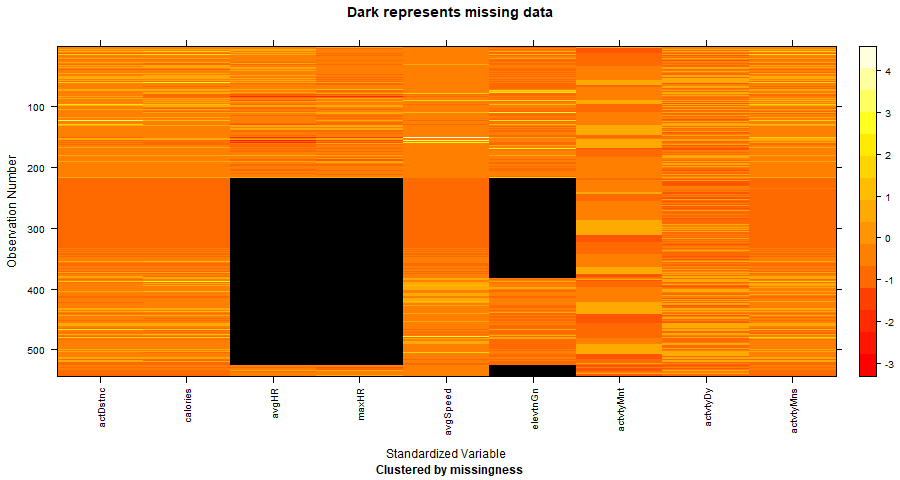

In [104]:
%%R -i activity_tracker_data_continuous -w 900 -h 480 -u px

library(vcd)
library(dplyr)
library(readr)
library(grid) # for gpar
library(RColorBrewer)
library(scales)
library(knitr)
library(mi)

image(missing_data.frame(activity_tracker_data_continuous))

rm(list = ls())

** *Visualization : Missing Data 2* **


 Variables sorted by number of missings: 
      Variable Count
         avgHR   307
         maxHR   307
 elevationGain   184
      avgSpeed     1
   actDistance     0
      calories     0
 activityMonth     0
   activityDay     0
  activityMins     0


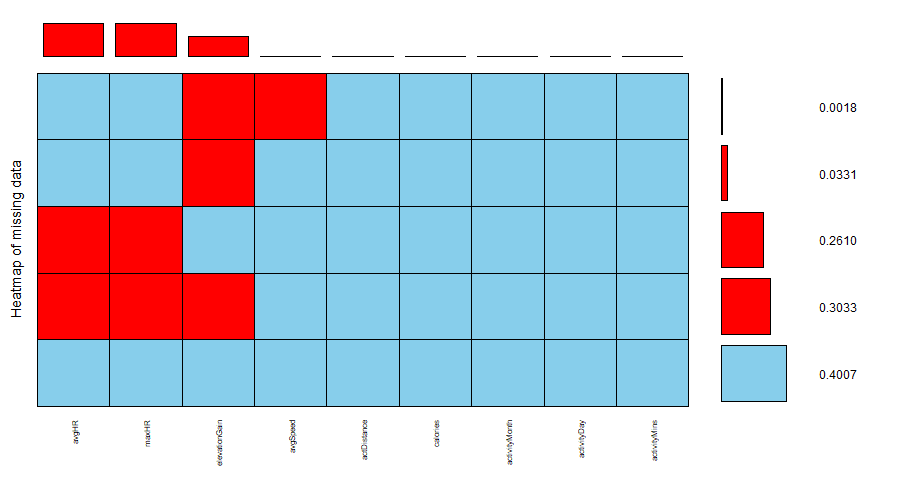

In [105]:
%%R -i activity_tracker_data_continuous -w 900 -h 480 -u px

library(vcd)
library(dplyr)
library(grid) # for gpar
library(RColorBrewer)
library("VIM")
library("mice")
#library(lattice)

aggr_plot <- aggr(activity_tracker_data_continuous, col=c('skyblue','red'), numbers=TRUE, sortVars=TRUE, labels=names(activity_tracker_data_continuous), cex.axis=.7, gap=3, ylab=c("Heatmap of missing data"), combined= TRUE)
rm(list = ls())

** *Visualizing Distribution of Continuous Variables* **


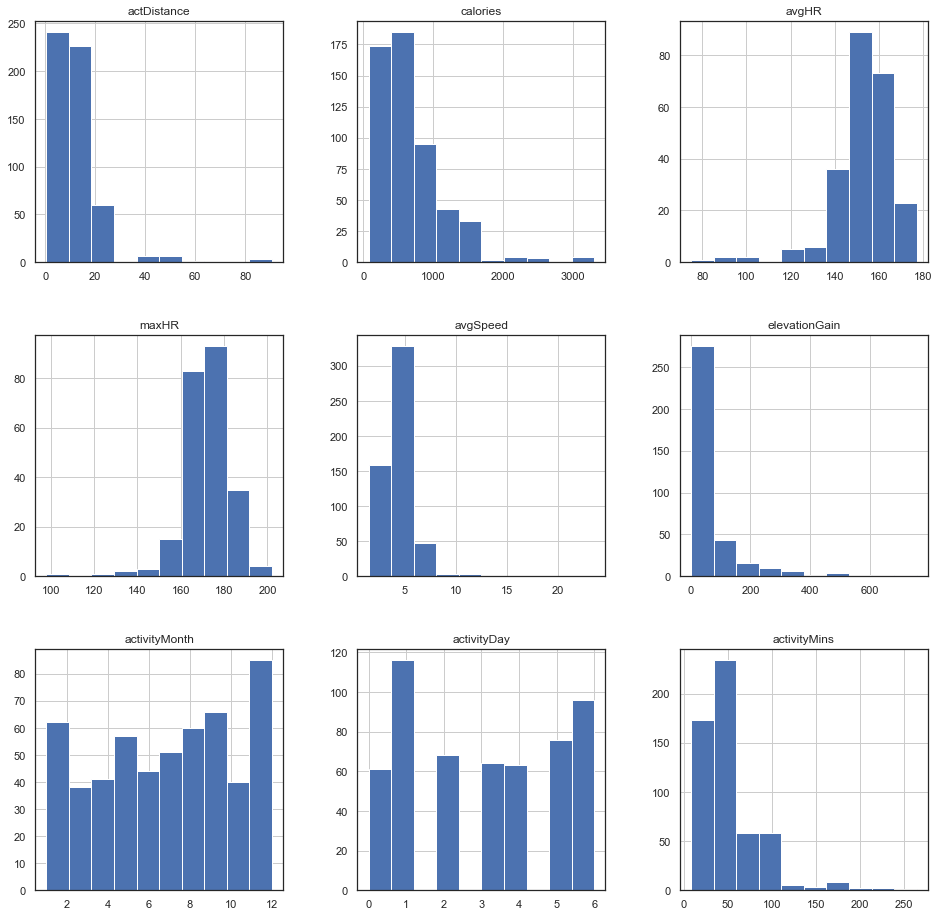

In [106]:
_ = activity_tracker_data.hist(column=continuous_vars, figsize = (16,16))

### vi. Visualizing Distribution of Categorical Variables

In [107]:
print(categorical_vars)

Index(['activityType', 'activityMonthName', 'activityDayName',
       'activityLevel'],
      dtype='object')


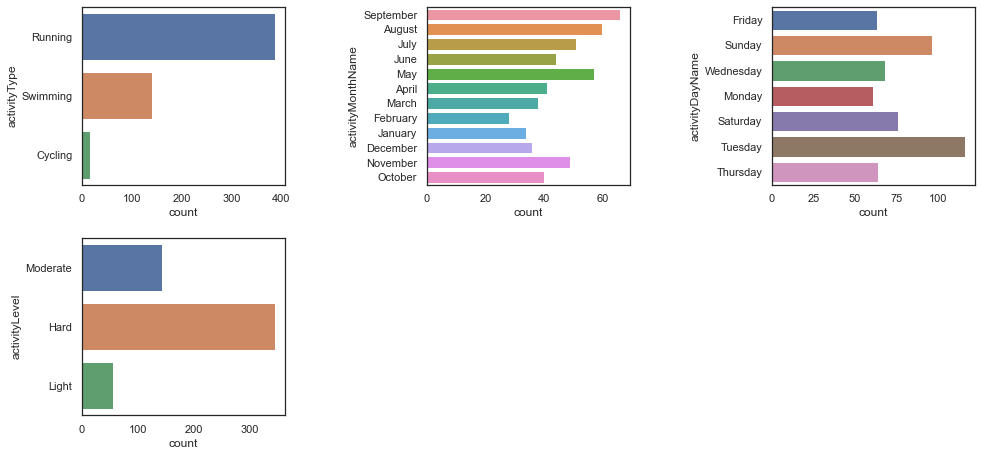

In [108]:
# Count plots of categorical variables

fig, axes = plt.subplots(4, 3, figsize=(16, 16))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 3:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_vars[i], data=activity_tracker_data, ax=ax)

### vii. Multivariate Distributions for Continuous Data

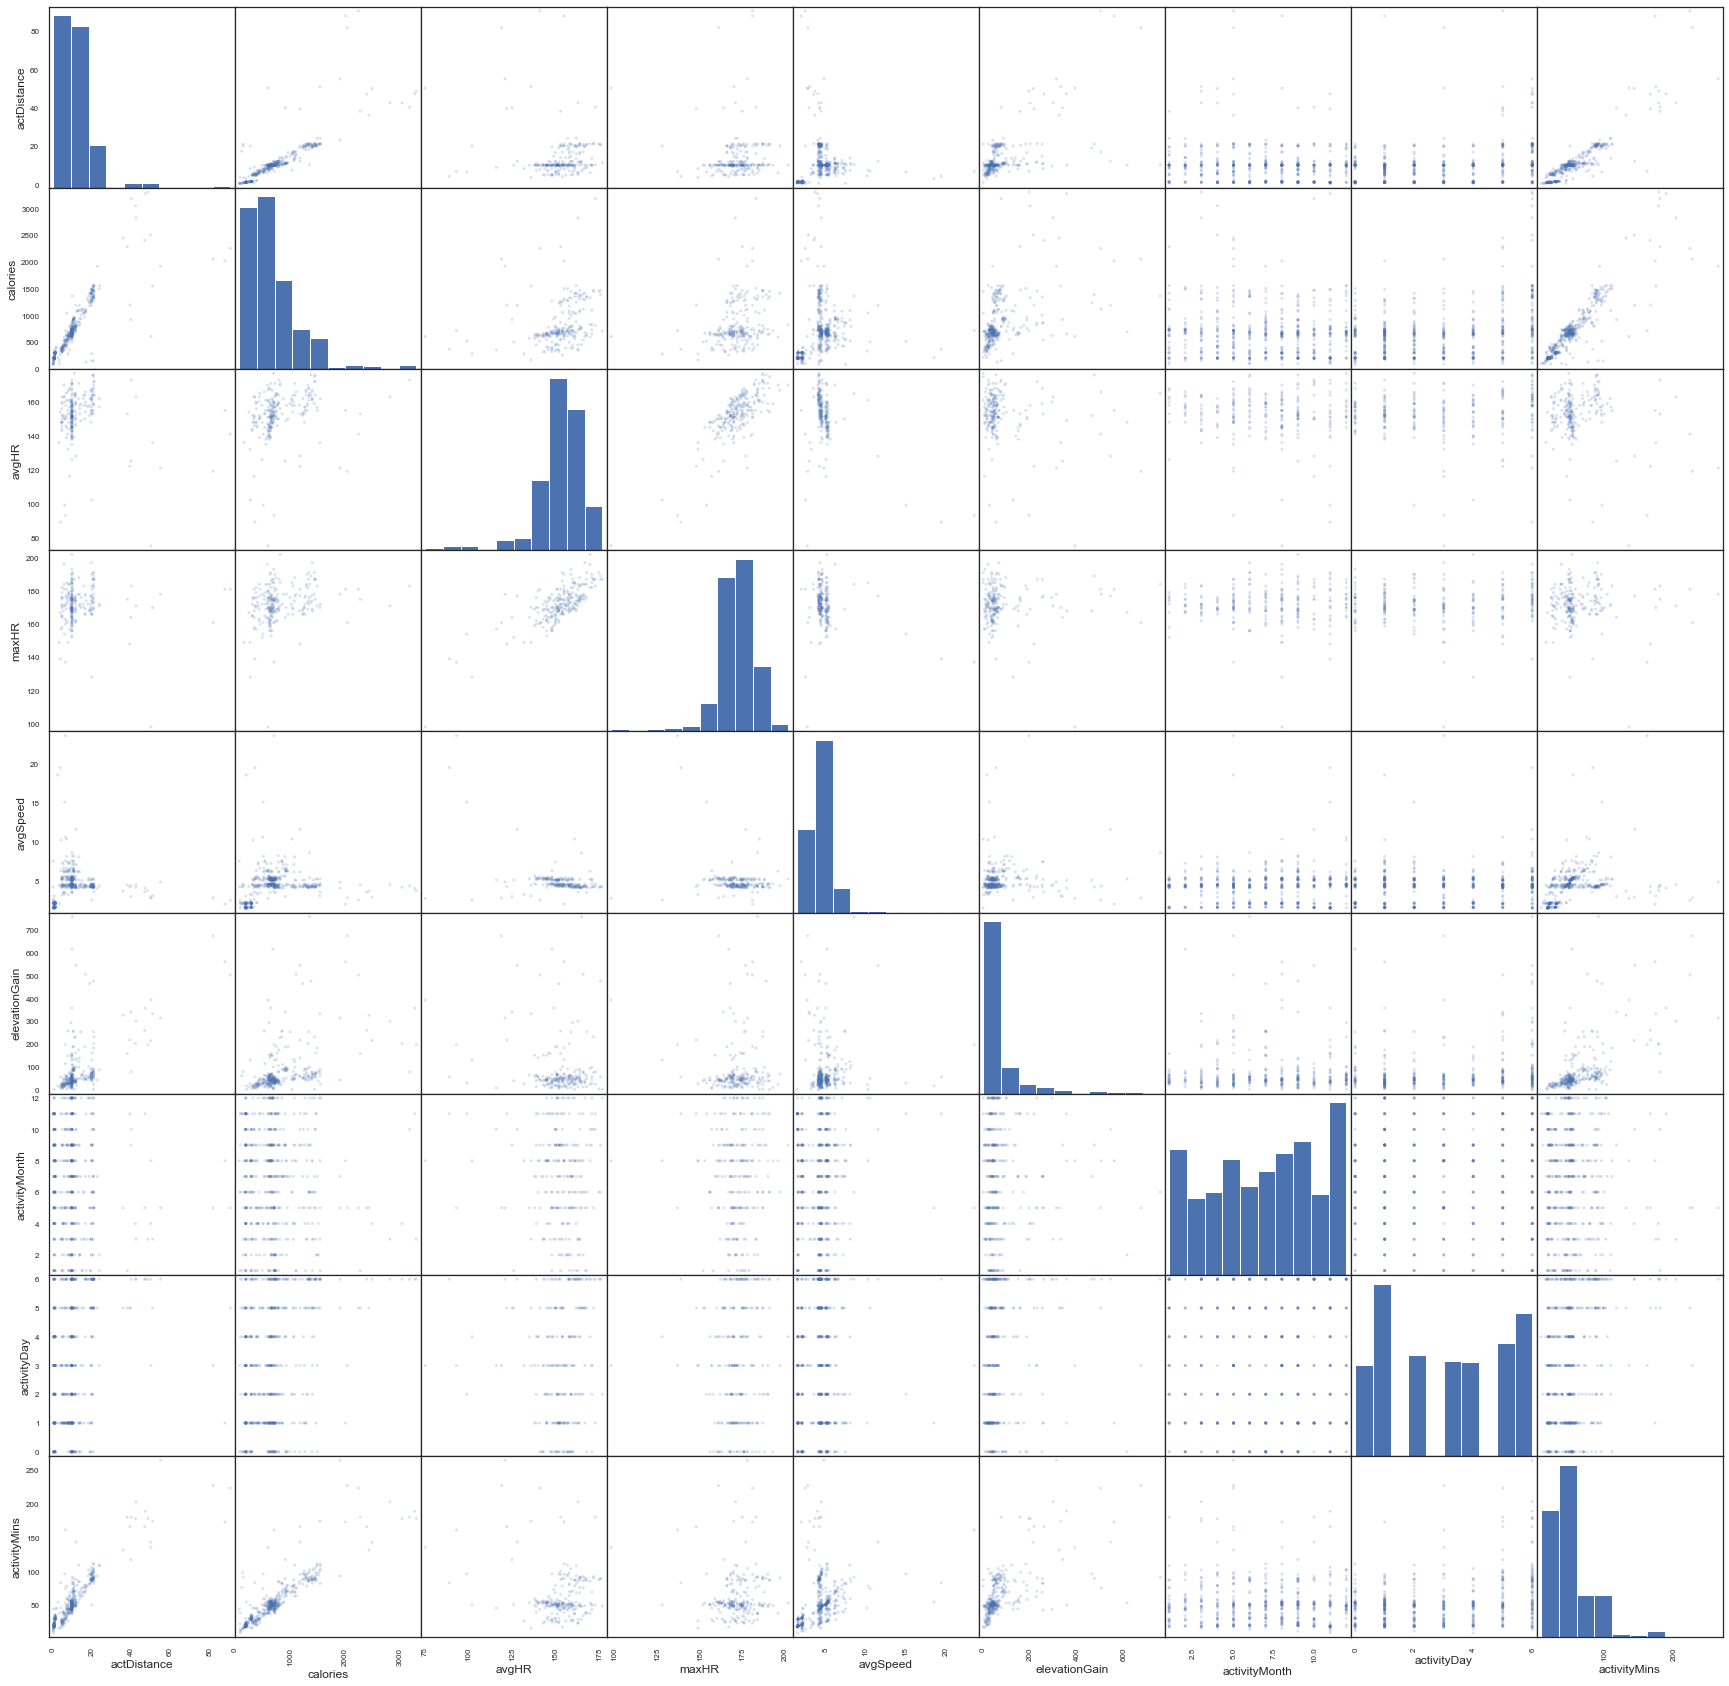

In [109]:
from pandas.plotting import scatter_matrix
_ = scatter_matrix(activity_tracker_data, alpha=0.2, figsize=(30, 30))

** Analysis of the above visualization: **

A Scatterplot matrices is a great way to roughly determine if you have a linear correlation between multiple variables. This is particularly helpful in pinpointing specific variables that might have similar correlations amongst the dataset. Some observations are as follows:

* Calories burnt show approximately linear correlation with the minutes of a particular activity and the steps taken. 
* Heteroskedasticity is observed for variables calories with activity Minutes and also activityMins and elevationGain.

** In this section, we will analyze the identified important features through our data quality analysis, namely, `Activity Minutes`, `Activity Month`, `Activity Day` and `Calories Burnt`. **

<a id="section1"></a>

### i. Analysis of the feature - Activity Minutes 

** *a. Distribution Histogram with overlayed Density Plots, with varying binwidths also* **

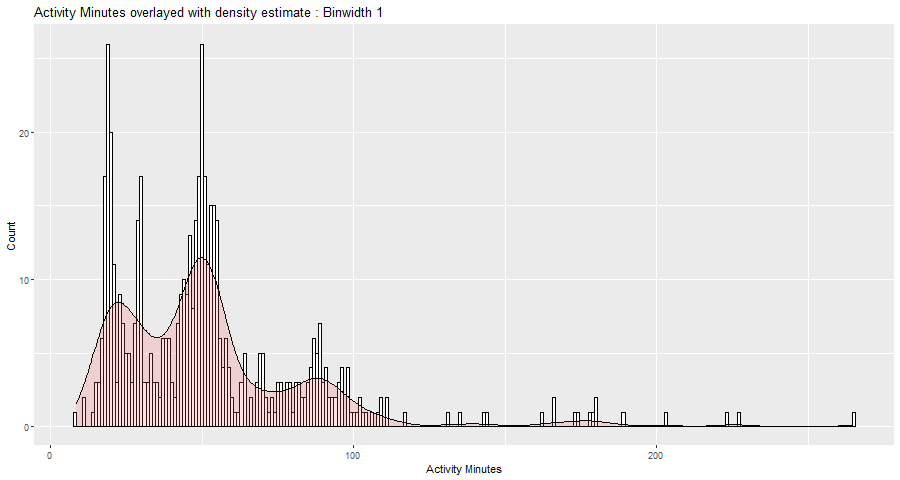

In [110]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

g1 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=1,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 1") 
g1

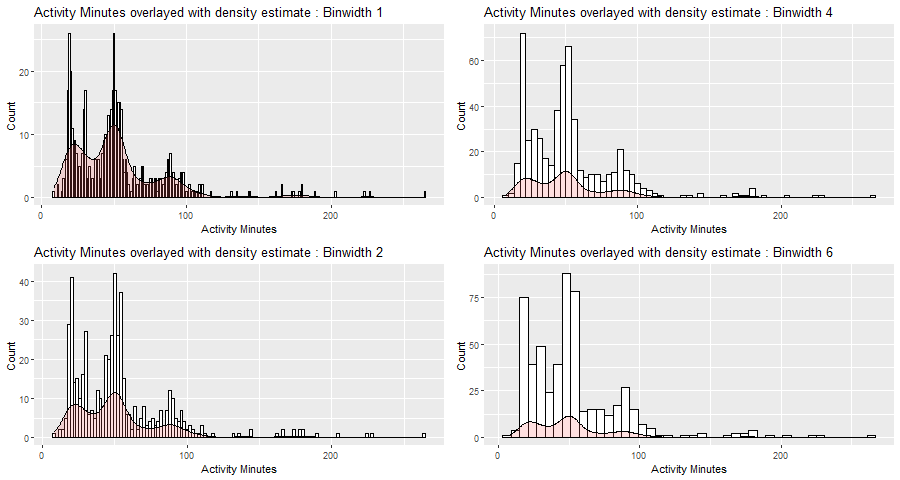

In [111]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    for (i in 1:numPlots) {
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}
g1 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=1,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 1")

g2 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=2,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 2")

g3 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=4,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 4")

g4 <- ggplot(activity_tracker_data, aes(x=activityMins)) + 
    geom_histogram(aes(y=..count..),      # Histogram with density instead of count on y-axis
                   binwidth=6,
                   colour="black", fill="white") +
    geom_density(aes(y=..count..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Count") +
    xlab("Activity Minutes") +
    ggtitle("Activity Minutes overlayed with density estimate : Binwidth 6")

multiplot(g1, g2, g3, g4, cols=2)

** *c. Analysis of Outliers : Activity Minutes for the activities* **

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



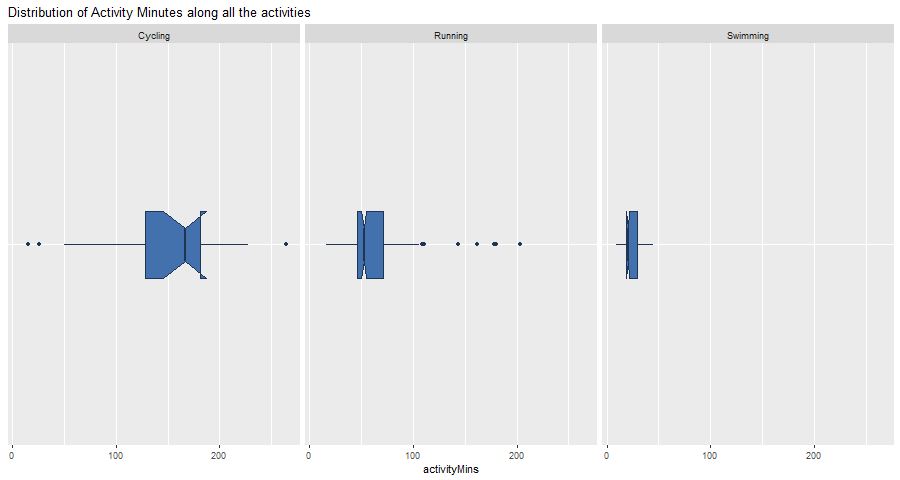

In [112]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

fill <- "#4271AE"
line <- "#1F3552"

ggplot(activity_tracker_data, aes(x=factor(1), y=activityMins)) + geom_boxplot(fill = fill, colour = line, notch = TRUE, width=0.2) +
    guides(fill=FALSE) + coord_flip() + 
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
    ggtitle("Distribution of Activity Minutes along all the activities") + facet_wrap( ~ activityType)

<a id="section2"></a>

### ii. Analysis of the feature - Activity Month

** *a. How many total activities have I done in every month for the past 5 years?* **

In [113]:
activity_tracker_data_gMonth = activity_tracker_data.groupby("activityMonthName").count()
activity_tracker_data_gMonth = activity_tracker_data_gMonth[["activityMonth"]]
activity_tracker_data_gMonth.reset_index(inplace=True)
activity_tracker_data_gMonth.rename(columns={'activityMonth':'Count'}, inplace=True)
# activity_tracker_data_gMonth.head()

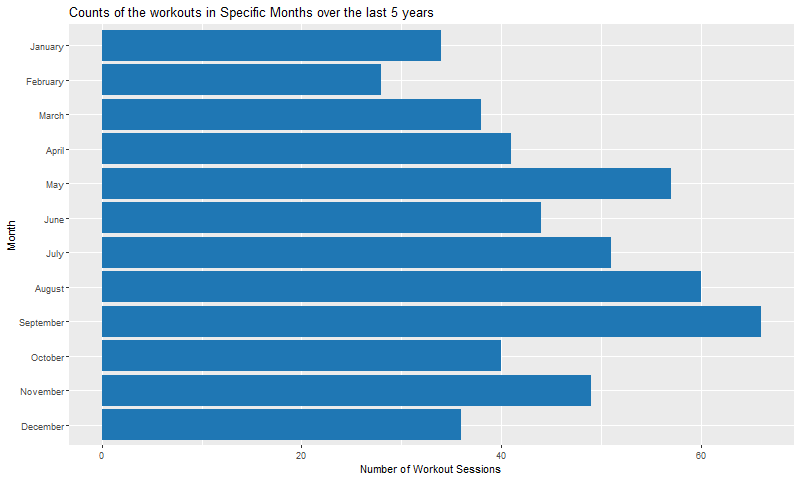

In [114]:
%%R -i activity_tracker_data_gMonth -w 800 -h 480 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
activity_tracker_data_gMonth$activityMonthName <- factor(activity_tracker_data_gMonth$activityMonthName, levels = rev(orderedclasses))

ggplot(activity_tracker_data_gMonth, aes(x = activityMonthName, y = Count)) + 
  geom_col(fill = "#1f77b4") + 
  coord_flip() +
  theme(legend.position="none") +
  xlab("Month") +
  ylab("Number of Workout Sessions") + 
  ggtitle("Counts of the workouts in Specific Months over the last 5 years")

** *b. How many specific activities have I done in every month for the past 5 years?* **

In [115]:
activity_tracker_data["activityYear"] = activity_tracker_data.startTime.dt.year

In [116]:
activity_tracker_data_gMonth = activity_tracker_data.groupby(["activityYear", "activityMonthName", "activityType"]).count()

In [117]:
activity_tracker_data_gMonth = activity_tracker_data_gMonth[["activityMonth"]]
activity_tracker_data_gMonth.reset_index(inplace=True)
activity_tracker_data_gMonth.rename(columns={'activityMonth':'Count'}, inplace=True)

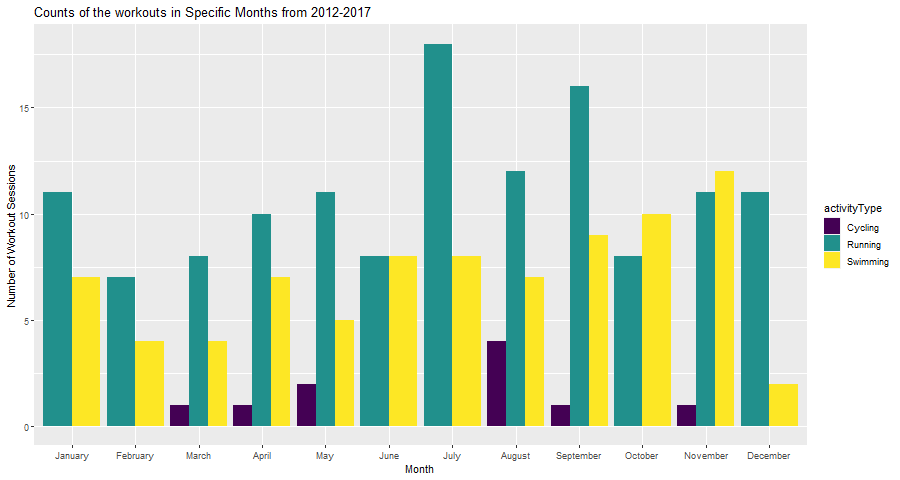

In [118]:
%%R -i activity_tracker_data_gMonth -w 900 -h 480 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
activity_tracker_data_gMonth$activityMonthName <- factor(activity_tracker_data_gMonth$activityMonthName, levels = orderedclasses)

ggplot(activity_tracker_data_gMonth, aes(x = activityMonthName, y = Count, fill = activityType)) + 
  geom_col(position="dodge") + 
  xlab("Month") +
  ylab("Number of Workout Sessions") +
  ggtitle("Counts of the workouts in Specific Months from 2012-2017") + scale_fill_viridis(discrete=TRUE)

** *c. Faceted by Year of the activity* **

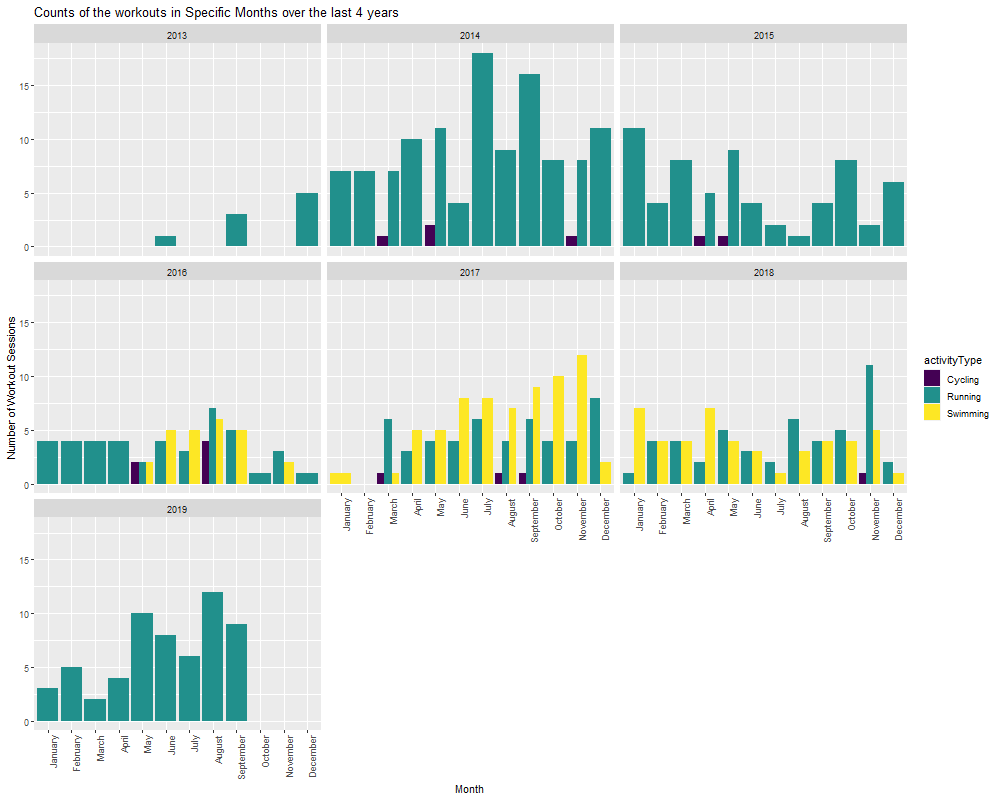

In [119]:
%%R -i activity_tracker_data_gMonth -w 1000 -h 800 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
activity_tracker_data_gMonth$activityMonthName <- factor(activity_tracker_data_gMonth$activityMonthName, levels = orderedclasses)

ggplot(activity_tracker_data_gMonth, aes(x = activityMonthName, y = Count, fill = activityType)) + 
  geom_col(position="dodge") + facet_wrap(~ activityYear) +
  xlab("Month") + 
  ylab("Number of Workout Sessions") +
  ggtitle("Counts of the workouts in Specific Months over the last 4 years") + scale_fill_viridis(discrete=TRUE) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

### iii. Analysis of the feature - Activity Day

A summary for both the visualizations made for the feature analysis of Activity Day has been provided in the end.

** *a. Which activities on which day of the week?* **

In [120]:
activity_tracker_data_activDay = activity_tracker_data.groupby(["activityDayName", "activityType"])[['activityDay']].count()
activity_tracker_data_activDay.rename(columns={'activityDay':'Count'}, inplace=True)
activity_tracker_data_activDay.reset_index(inplace=True)
#activity_tracker_data_activDay

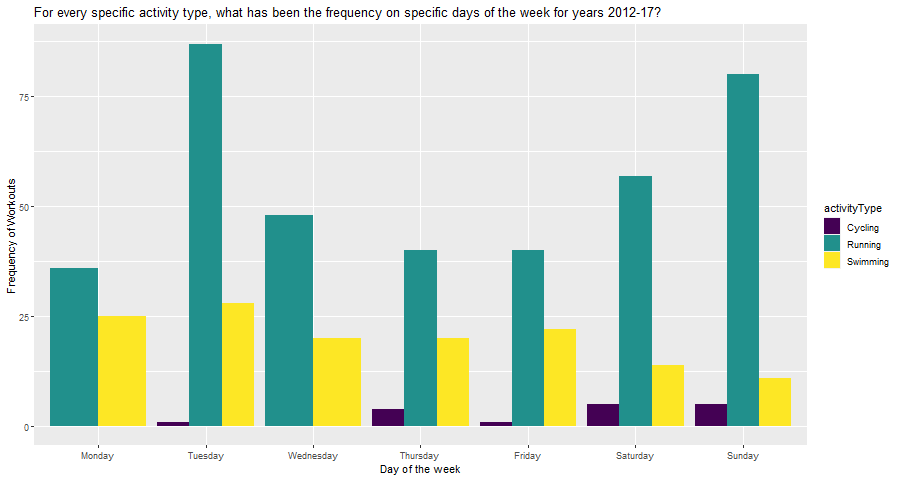

In [121]:
%%R -i activity_tracker_data_activDay -w 900 -h 480 -u px

library(tidyverse)
library(ggplot2)
library(gridExtra)
require("viridis")

orderedclasses <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
activity_tracker_data_activDay$activityDayName <- factor(activity_tracker_data_activDay$activityDayName, levels = orderedclasses)


g1 <- ggplot(activity_tracker_data_activDay, aes(x = activityDayName, y = Count, fill=activityType)) +
  geom_col(position = "dodge") +  scale_fill_viridis(discrete=TRUE) + 
  xlab("Day of the week") +
  ylab("Frequency of Workouts") +
  ggtitle("For every specific activity type, what has been the frequency on specific days of the week for years 2012-17?")
g1

** *b. Which activities on which day of the week, faceted by activity?* **

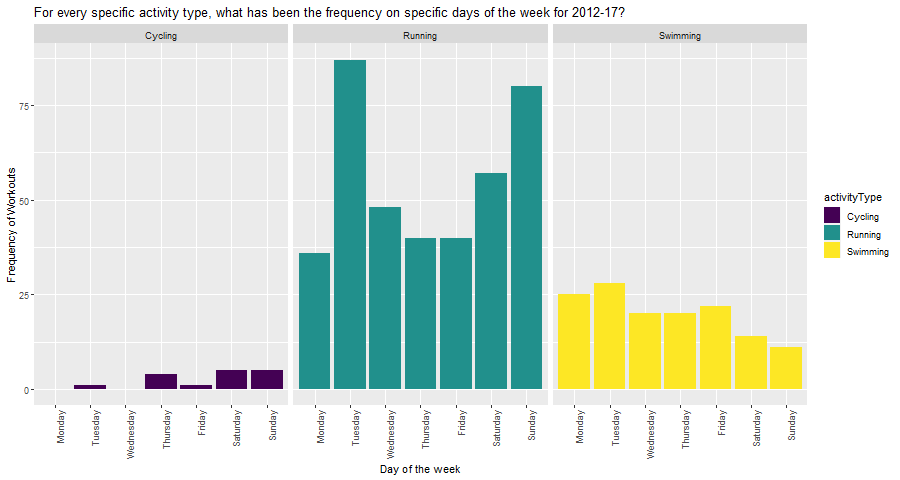

In [122]:
%%R -i activity_tracker_data_activDay -w 900 -h 480 -u px

orderedclasses <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
activity_tracker_data_activDay$activityDayName <- factor(activity_tracker_data_activDay$activityDayName, levels = orderedclasses)

g2 <- ggplot(activity_tracker_data_activDay, aes(x = activityDayName, y = Count, fill=activityType)) +
  geom_col() + facet_wrap(~activityType) + scale_fill_viridis(discrete=TRUE) +
  xlab("Day of the week") +
  ylab("Frequency of Workouts") + theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  ggtitle("For every specific activity type, what has been the frequency on specific days of the week for 2012-17?")
g2

### iv. Analysis of the feature - Calories Burnt 

** *a. Distribution Histogram with overlayed Density Plots and also with varying binwidths* **

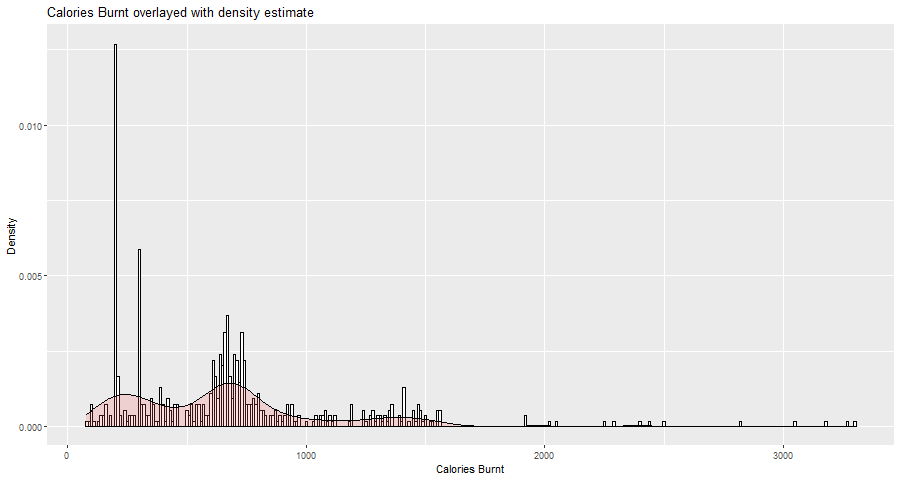

In [123]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=10,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

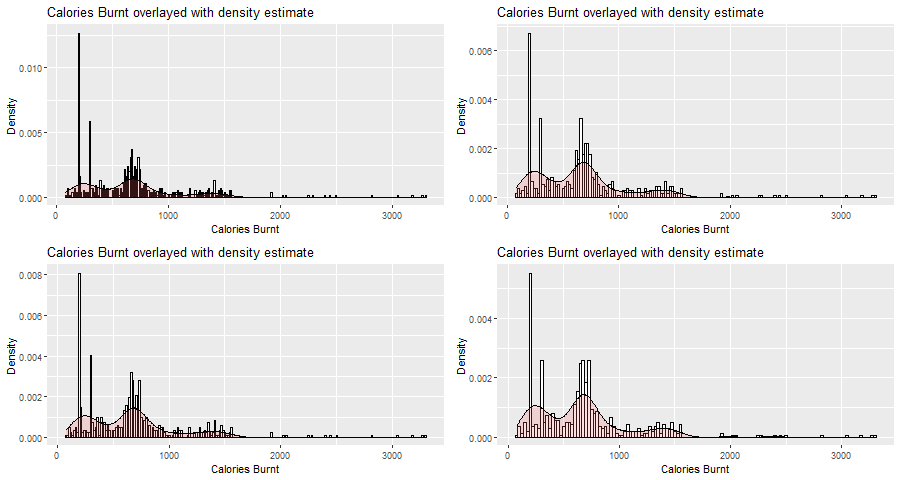

In [124]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

g1 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=10,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

g2 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=15,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

g3 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=20,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

g4 <- ggplot(activity_tracker_data, aes(x=calories)) + 
    geom_histogram(aes(y=..density..),      # Histogram with density instead of count on y-axis
                   binwidth=25,
                   colour="black", fill="white") +
    geom_density(aes(y=..density..), alpha=.2, fill="#FF6666") +# Overlay with transparent density plot
    ylab("Density") +
    xlab("Calories Burnt") +
    ggtitle("Calories Burnt overlayed with density estimate")

multiplot(g1, g2, g3, g4, cols=2)

** *b. Distribution of Calories Burnt across various Activities* **

** *c. Outlier Analysis of Calories Burnt across various Activities* **

R[write to console]: notch went outside hinges. Try setting notch=FALSE.

R[write to console]: notch went outside hinges. Try setting notch=FALSE.



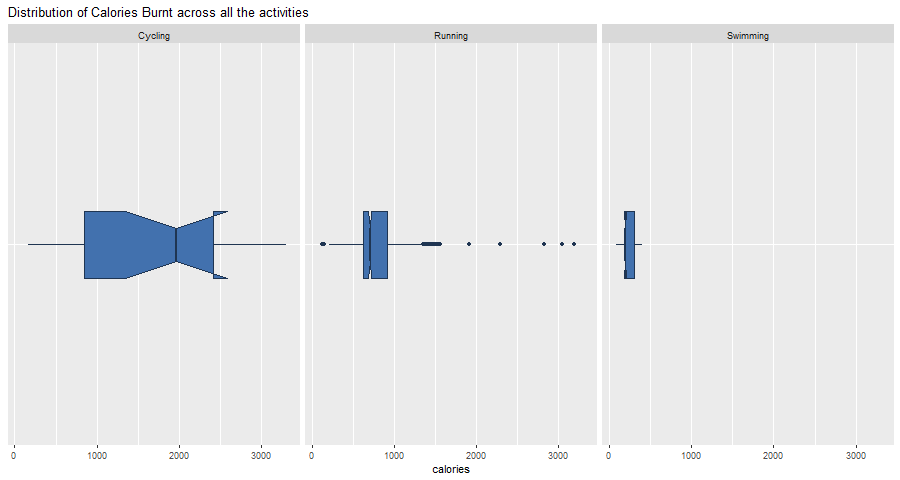

In [125]:
%%R -i activity_tracker_data -w 900 -h 480 -u px

require("ggplot2")

fill <- "#4271AE"
line <- "#1F3552"

ggplot(activity_tracker_data, aes(x=factor(1), y=calories)) + geom_boxplot(fill = fill, colour = line, notch = TRUE, width=0.2) +
    guides(fill=FALSE) + coord_flip() + 
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
    ggtitle("Distribution of Calories Burnt across all the activities") + facet_wrap( ~ activityType)

In [126]:
year_month_act_mins = activity_tracker_data.groupby(["activityYear", "activityMonthName", "activityType"]).activityMins.agg(["sum"])
year_month_act_mins.reset_index(inplace=True)
#year_month_act_mins

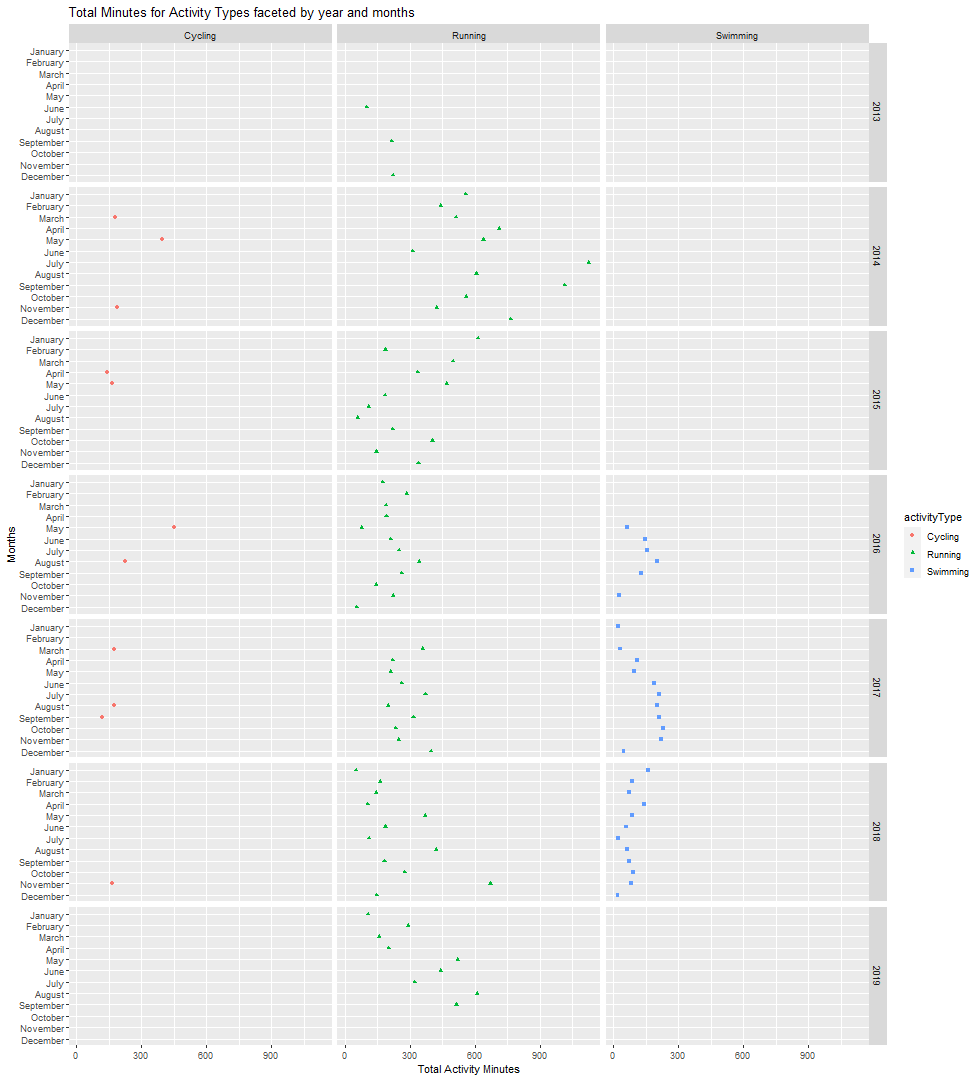

In [127]:
%%R -i year_month_act_mins -w 980 -h 1080 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
year_month_act_mins$activityMonthName <- factor(year_month_act_mins$activityMonthName, levels = rev(orderedclasses))

g1 <- ggplot(year_month_act_mins, aes(x=sum, y=activityMonthName)) + 
    geom_point(aes(color=activityType, shape = activityType)) +
    ylab("Months") + scale_fill_viridis(discrete=TRUE) +
    xlab("Total Activity Minutes") +
    ggtitle("Total Minutes for Activity Types faceted by year and months ") + 
    facet_grid(activityYear ~ activityType)
g1

### x. Analyzing average calories burnt for every activity type during the months of years 2012-17

In [128]:
year_month_cal_mins = activity_tracker_data.groupby(["activityYear", "activityMonthName", "activityType"]).calories.agg(["mean"])
year_month_cal_mins.reset_index(inplace=True)
#year_month_cal_mins

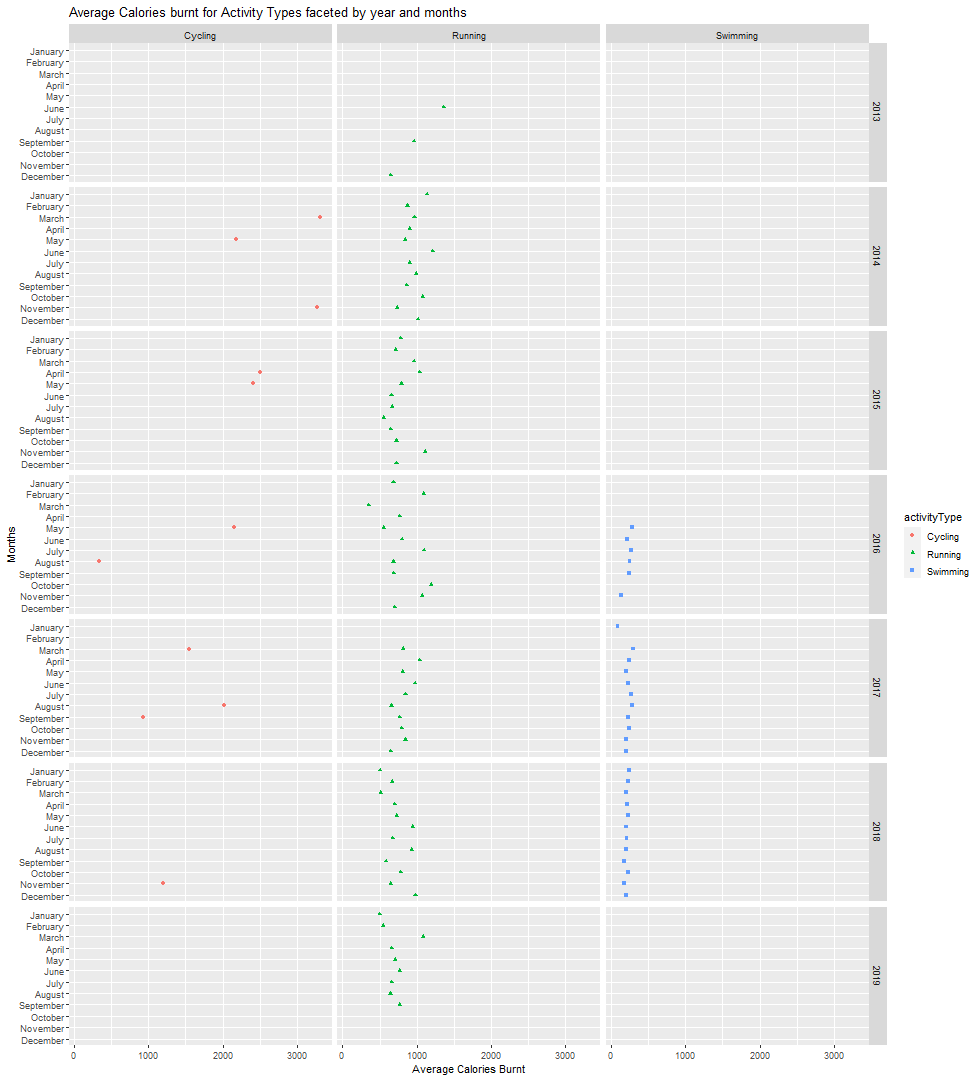

In [129]:
%%R -i year_month_cal_mins -w 980 -h 1080 -u px

require("ggplot2")
require("viridis")

orderedclasses <- c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December")
year_month_cal_mins$activityMonthName <- factor(year_month_act_mins$activityMonthName, levels = rev(orderedclasses))

g1 <- ggplot(year_month_cal_mins, aes(x=mean, y=activityMonthName)) + 
    geom_point(aes(color=activityType, shape = activityType)) +
    ylab("Months") + scale_fill_viridis(discrete=TRUE) +
    xlab("Average Calories Burnt") +
    ggtitle("Average Calories burnt for Activity Types faceted by year and months ") + 
    facet_grid(activityYear ~ activityType)
g1

### xi. How have my activity levels (based on average Heart Rate) varied along the chosen aggregations?

** *a. Activity Levels and their variation along the aggregated days of the week* **

In [130]:
activity_tracker_data_rec = activity_tracker_data.loc[activity_tracker_data["activityLevel"] != "Not Recorded", :]

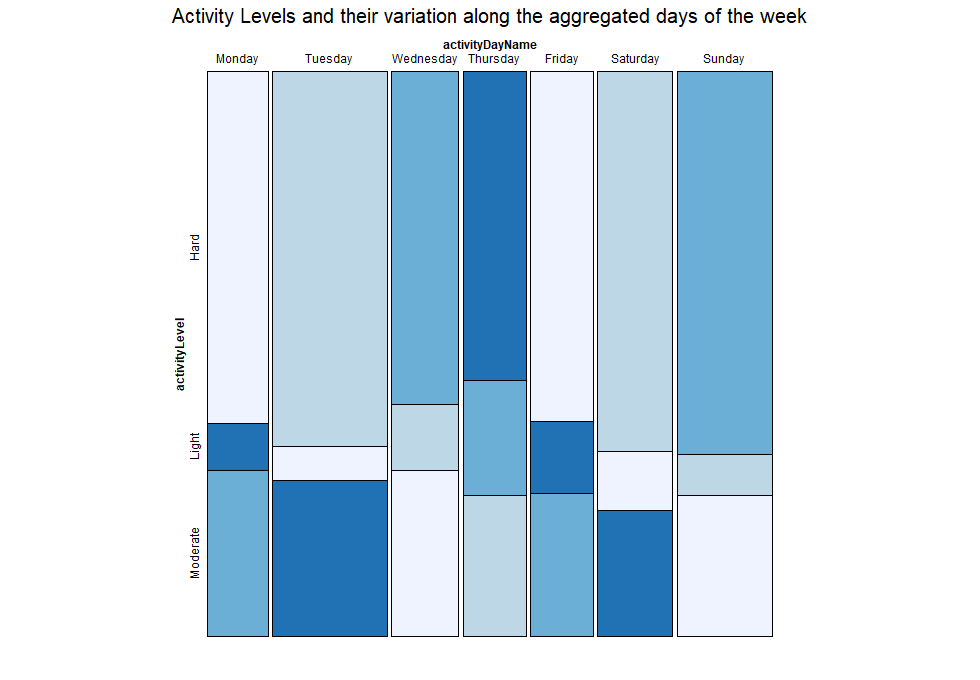

In [131]:
%%R -i activity_tracker_data_rec -w 980 -h 680 -u px


library(vcd)
library(RColorBrewer)

mycolors <- brewer_pal(type = "seq")(4)

orderedclasses <- c("Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
activity_tracker_data_rec$activityDayName <- factor(activity_tracker_data_rec$activityDayName, levels = orderedclasses)

vcd::mosaic(activityLevel ~ activityDayName, data = activity_tracker_data_rec, gp = gpar(fill = mycolors), direction = c("v", "h"),
            main = "Activity Levels and their variation along the aggregated days of the week")


** *b. Activity Levels and their variation along the aggregated activities* **

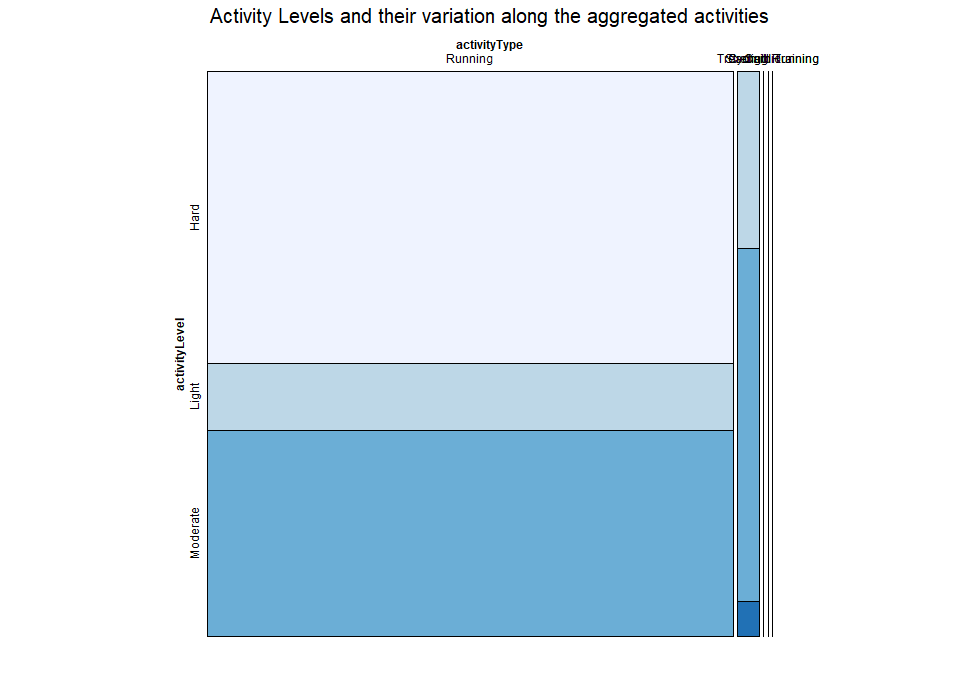

In [132]:
%%R -i activity_tracker_data_rec -w 980 -h 680 -u px


library(vcd)
library(RColorBrewer)

mycolors <- brewer_pal(type = "seq")(4)

orderedclasses <- c("Running", "Cycling", "Cardio", "Treadmill Running", "Strength Training")
activity_tracker_data_rec$activityType <- factor(activity_tracker_data_rec$activityType, levels = orderedclasses)

vcd::mosaic(activityLevel ~ activityType, data = activity_tracker_data_rec, gp = gpar(fill = mycolors), direction = c("v", "h", "v"),
            main = "Activity Levels and their variation along the aggregated activities")



In [133]:
import seaborn.apionly as sns
import numpy as np
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import sys
import os,fnmatch
import matplotlib as mpl
import matplotlib.cm as cm

<AxesSubplot:xlabel='activityMins', ylabel='activityLevel'>

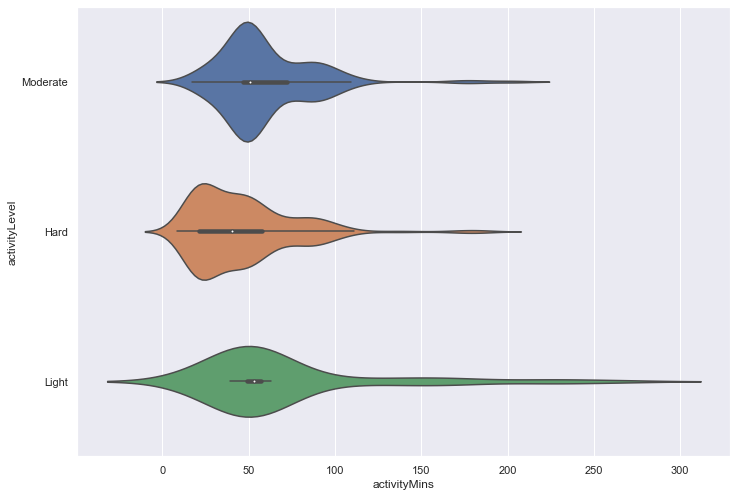

In [134]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x=activity_tracker_data.activityMins,y=activity_tracker_data.activityLevel)

<AxesSubplot:xlabel='activityDay', ylabel='activityMins'>

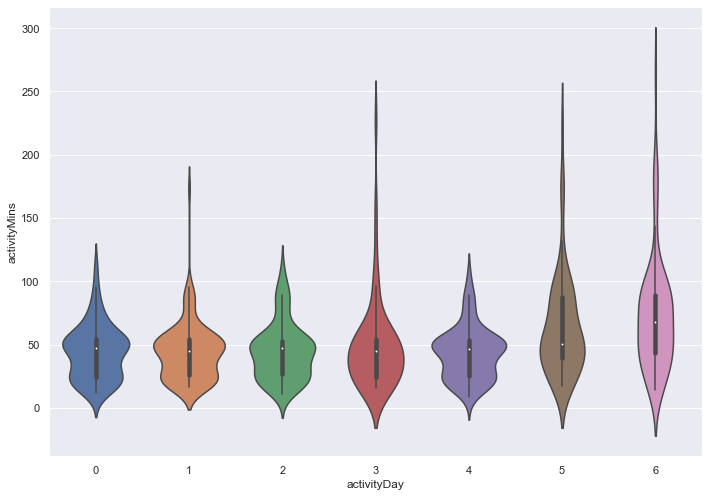

In [135]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.violinplot(x=activity_tracker_data.activityDay,y=activity_tracker_data.activityMins)

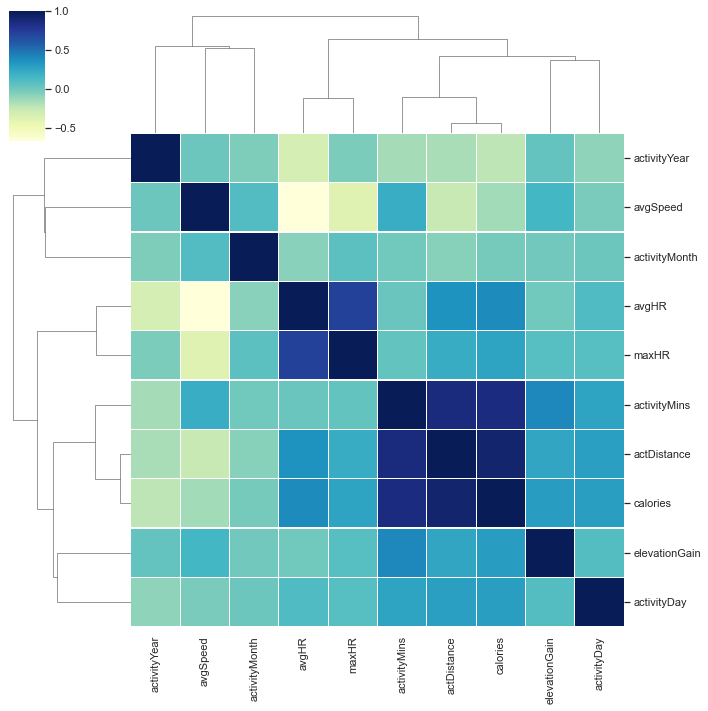

In [136]:
# select only running activity and make a generic correlation analysis
corr_analysis_data = activity_tracker_data.loc[activity_tracker_data['activityType']=='Running']
corrmat = corr_analysis_data.corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg 

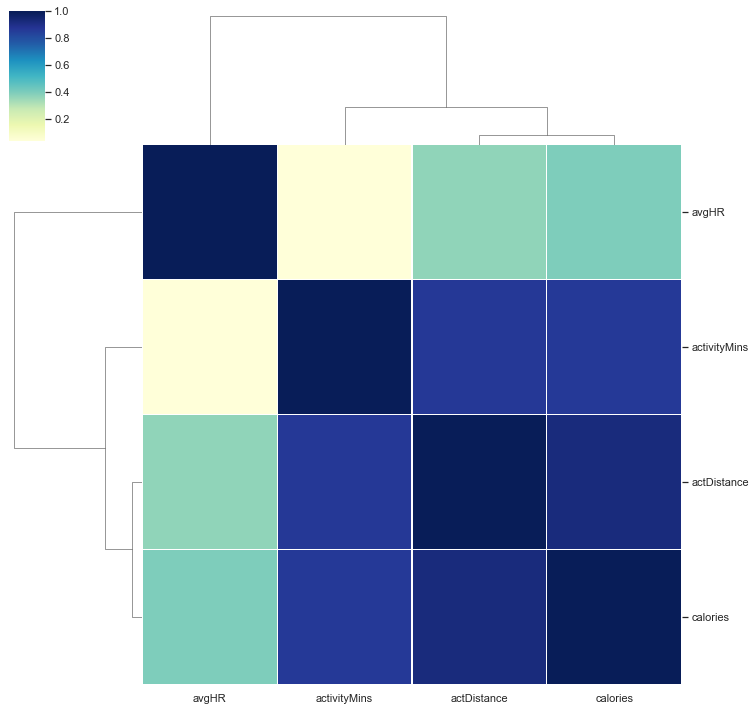

In [137]:
# select only running activity and a limited correlation analysis on some variables
corr_analysis_data = activity_tracker_data.loc[activity_tracker_data['activityType']=='Running']
corr_analysis_data = corr_analysis_data[['actDistance','calories','avgHR','activityMins','activityLevel']]
corrmat = corr_analysis_data.corr() 
cg = sns.clustermap(corrmat, cmap ="YlGnBu", linewidths = 0.1); 
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0) 
cg 

In [138]:
# we have 4 predictor variables and one label
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
#corr_analysis_data['activityLevel'] = labelencoder.fit_transform(corr_analysis_data['activityLevel'])

In [139]:
import numpy
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from sklearn import neighbors
import matplotlib.patches as mpatches
import graphviz
from sklearn.tree import export_graphviz
import matplotlib.patches as mpatches

In [140]:
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(numpy.arange(c_features), feature_names)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()


def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = numpy.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = numpy.meshgrid(numpy.arange(x_min-k, x_max+k, h), numpy.arange(y_min-k, y_max+k, h))

    P = clf.predict(numpy.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    fig=plt.figure(dpi=100)
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()
    #fig.savefig("RBF.svg", format="svg")

# Intensity level classification

In [141]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [142]:
X = corr_analysis_data[['actDistance','calories','avgHR','activityMins']]
y = corr_analysis_data[['activityLevel']]
# handle nans in a reasonable way
X['calories'].fillna(X['calories'].mean(), inplace=True)
X['avgHR'].fillna(X['avgHR'].median(), inplace=True)
X['calories'] = X['calories'] + np.random.randint(50, 150, *X['calories'].shape)
X['avgHR'] = X['avgHR'] + np.random.randint(1, 15, *X['avgHR'].shape)

In [143]:
# extract the most relevant features
# perform a Xisquared test to the samples to retrieve only the two best features 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_new = SelectKBest(chi2, k=2).fit_transform(X, y)
#based on the most relevant features prepare data for classification
rel_feat1 = X.columns[(X == X_new[0][0]).any()][0]
rel_feat2 = X.columns[(X == X_new[0][1]).any()][0]
# extract those columns with the most relevant features
X = X[[X.columns[(X == X_new[0][0]).any()][0], X.columns[(X == X_new[0][1]).any()][0]]]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# LinearSVC with M classes generates M one vs rest classifiers.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_train)
y_pred = clf.predict(X_test)

In [ ]:
# we have 4 predictor variables and one label
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
label_vals = labelencoder.fit_transform(y['activityLevel'])

In [ ]:
from matplotlib.colors import ListedColormap


plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b', 'y']
cmap_activities = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFFF00'])

plt.scatter(X[['calories']], X[['avgHR']],
           c=label_vals, cmap=cmap_activities, edgecolor = 'black', alpha=.7)

x_0_range = np.linspace(0, 1800)

for w, b, color in zip(clf.coef_, clf.intercept_, ['r', 'g', 'b', 'y']):
    plt.plot(x_0_range, -(x_0_range * w[0] + b) / w[1], c=color, alpha=.9)
    
plt.legend(y['activityLevel'].unique())
plt.xlabel('calories')
plt.ylabel('avgHR')
plt.xlim(0, 1900)
plt.ylim(90, 250)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=y['activityLevel'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(clf, X_test, y_test)

Hausaufgabe! Bessere Klassifikator:) 

# Acitivity classification

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
corr_analysis_data = activity_tracker_data[['activityType','calories','avgHR']]

In [ ]:
X = corr_analysis_data[['calories','avgHR']]
y = corr_analysis_data[['activityType']]
# handle nans in a reasonable way
X['calories'].fillna(X['calories'].mean(), inplace=True)
X['avgHR'].fillna(X['avgHR'].median(), inplace=True)
X['calories'] = X['calories'] + np.random.randint(50, 150, *X['calories'].shape)
X['avgHR'] = X['avgHR'] + np.random.randint(5, 15, *X['avgHR'].shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# LinearSVC with M classes generates M one vs rest classifiers.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10)
clf = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='balanced'))
clf.fit(X_train, y_train)
proba = clf.predict_proba(X_train)
y_pred = clf.predict(X_test)

In [ ]:
# we have 4 predictor variables and one label
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
label_vals = labelencoder.fit_transform(y['activityType'])

In [ ]:
from matplotlib.colors import ListedColormap


plt.figure(figsize=(6,6))
colors = ['r', 'g', 'b', 'y']
cmap_activities = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#FFFF00'])

plt.scatter(X[['calories']], X[['avgHR']],
           c=label_vals, cmap=cmap_activities, edgecolor = 'black', alpha=.7)

x_0_range = np.linspace(0, 1800)

for w, b, color in zip(clf.coef_, clf.intercept_, ['r', 'g', 'b', 'y']):
    plt.plot(x_0_range, -(x_0_range * w[0] + b) / w[1], c=color, alpha=.9)
    
plt.legend(y['activityType'].unique())
plt.xlabel('calories')
plt.ylabel('avgHR')
plt.xlim(0, 1900)
plt.ylim(60, 200)
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=y['activityType'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(clf, X_test, y_test)